In [1]:
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
import numpy as np
import os
import json
import random
import cv2
import shutil

setup_logger()
dataset_dir = "dataset/"
train_dir = dataset_dir + "train"
val_dir = dataset_dir + "val"
classes = ["red", "pink", "yellow", "blue", "orange", "green"]
camera_rows = 516
camera_cols = 656

In [2]:
allFileNames = np.arange(50)
np.random.shuffle(allFileNames)
test_ratio = 0.8
is_new = False
if not os.path.isdir(dataset_dir +'train/'):
    os.makedirs(dataset_dir +'train/')
    is_new = True
if not os.path.isdir(dataset_dir +'val/'):
    os.makedirs(dataset_dir +'val/')
    is_new = True

if is_new:
    train_FileNames, val_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* test_ratio)])
    for name in train_FileNames:
        shutil.copy(dataset_dir+"test_"+str(name)+".jpg", "dataset/train")
        shutil.copy(dataset_dir+"test_"+str(name)+".json", "dataset/train")

    for name in val_FileNames:
        shutil.copy(dataset_dir+"test_"+str(name)+".jpg", "dataset/val")
        shutil.copy(dataset_dir+"test_"+str(name)+".json", "dataset/val")


In [3]:
def get_balloon_images():
    dataset_dicts = []
    for filename in [file for file in os.listdir(val_dir) if file.endswith('.json')]:
        json_file = os.path.join(val_dir, filename)
        with open(json_file) as f:
            img_label = json.load(f)

        record = {}
        
        img = os.path.join(val_dir, img_label["imagePath"])
        
        record["file_name"] = img
        record["height"] = camera_rows
        record["width"] = camera_cols
      
        shapes = img_label["shapes"]
        objs = []
        for shape in shapes:
            px = [a[0] for a in shape['points']] # x coord
            py = [a[1] for a in shape['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(shape['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [4]:
def my_dataset_function():
    dataset_dicts = []
    for filename in [file for file in os.listdir(train_dir) if file.endswith('.json')]:
        json_file = os.path.join(train_dir, filename)
        with open(json_file) as f:
            img_label = json.load(f)

        record = {}
        
        img = os.path.join(train_dir, img_label["imagePath"])
        
        record["file_name"] = img
        record["height"] = camera_rows
        record["width"] = camera_cols
      
        shapes = img_label["shapes"]
        objs = []
        for shape in shapes:
            px = [a[0] for a in shape['points']] # x coord
            py = [a[1] for a in shape['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(shape['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
DatasetCatalog.register(train_dir, my_dataset_function)

In [6]:
MetadataCatalog.get(train_dir).set(thing_classes=classes)

namespace(name='dataset/train',
          thing_classes=['red', 'pink', 'yellow', 'blue', 'orange', 'green'])

In [7]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (train_dir,)
#cfg.OUTPUT_DIR = "dataset"
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1200    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 10   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)


In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/03 22:41:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[07/03 22:41:02 d2.engine.train_loop]: Starting training from iteration 0


/home/stelios/anaconda3/envs/detectron2/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/03 22:41:07 d2.utils.events]:  eta: 0:05:26  iter: 19  total_loss: 4.837  loss_cls: 1.835  loss_box_reg: 0.4418  loss_mask: 0.6944  loss_rpn_cls: 1.459  loss_rpn_loc: 0.321  time: 0.2738  data_time: 0.0086  lr: 4.9953e-06  max_mem: 2236M
[07/03 22:41:12 d2.utils.events]:  eta: 0:05:17  iter: 39  total_loss: 4.033  loss_cls: 1.711  loss_box_reg: 0.6619  loss_mask: 0.6916  loss_rpn_cls: 0.663  loss_rpn_loc: 0.297  time: 0.2654  data_time: 0.0026  lr: 9.9902e-06  max_mem: 2236M
[07/03 22:41:18 d2.utils.events]:  eta: 0:05:12  iter: 59  total_loss: 3.178  loss_cls: 1.527  loss_box_reg: 0.5755  loss_mask: 0.6888  loss_rpn_cls: 0.116  loss_rpn_loc: 0.2252  time: 0.2670  data_time: 0.0024  lr: 1.4985e-05  max_mem: 2236M
[07/03 22:41:23 d2.utils.events]:  eta: 0:05:04  iter: 79  total_loss: 2.831  loss_cls: 1.206  loss_box_reg: 0.704  loss_mask: 0.6822  loss_rpn_cls: 0.03939  loss_rpn_loc: 0.216  time: 0.2661  data_time: 0.0024  lr: 1.998e-05  max_mem: 2236M
[07/03 22:41:29 d2.utils.events

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

[07/03 22:46:28 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

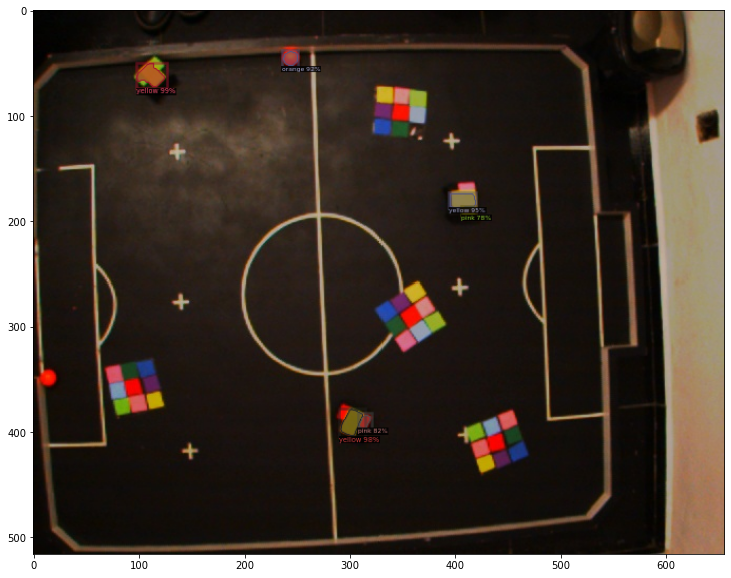

In [12]:
import matplotlib.pyplot as plt
im = cv2.imread(val_dir+"/test_0.jpg")
outputs = predictor(im[..., ::-1])
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])

In [11]:
#import IPython
#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)